In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import psycopg2

pd.options.display.max_columns = 40

## Hack for Heat #4: Number of complaints over time pt.2

In this post, we're going to look at the number of complaints each borough received for the last five or so years. First, let's look at the total number of complaints received:

In [3]:
connection = psycopg2.connect('dbname = threeoneone user=threeoneoneadmin password=threeoneoneadmin')
cursor = connection.cursor()

## Borough complaints by date


In [4]:
cursor.execute('''SELECT createddate, borough FROM service;''')
borodata = cursor.fetchall()

In [5]:
borodata = pd.DataFrame(borodata)

In [6]:
borodata.columns = ['Date', 'Boro']

In [7]:
borobydate = borodata.groupby(by='Boro').count()

In [8]:
borobydate

,Date
Boro,
BRONX,1882215
BROOKLYN,3178206
MANHATTAN,2166983
QUEENS,2444874
STATEN ISLAND,541935
Unspecified,1157085


For fun, let's look at the number of complaints per capita in each of the 5 boroughs. The population values below are from Wikipedia.

In [9]:
boropop = {
    'MANHATTAN': 1636268,
    'BRONX': 1438159,
    'BROOKLYN': 2621793,
    'QUEENS': 2321580,
    'STATEN ISLAND': 473279,
    }

In [10]:
borobydate['Pop'] = [boropop.get(x) for x in borobydate.index]

In [11]:
borobydate['CompPerCap'] = borobydate['Date']/borobydate['Pop']

In [12]:
borobydate

,Date,Pop,CompPerCap
Boro,,,
BRONX,1882215,1438159,1.308767
BROOKLYN,3178206,2621793,1.212226
MANHATTAN,2166983,1636268,1.324345
QUEENS,2444874,2321580,1.053108
STATEN ISLAND,541935,473279,1.145065
Unspecified,1157085,NaN,NaN


## Complaints by borough over months

The next thing we're going to do is make a stacked plot of complaints by borough, over months. To do this, we need to extract the day and month from the date column:

In [13]:
borodata['Year'] = [x.year for x in borodata['Date']]
borodata['Month'] = [x.month for x in borodata['Date']]

In [14]:
borodata = borodata.loc[borodata['Boro'] != 'Unspecified']

Next, we need to generate an array of Ys. We want the rows of this dataframe to be the 5 boroughs, and the columns to be the count of complaints for the year and month.

In [15]:
boroplotdata = borodata.groupby(by=['Boro', 'Year','Month']).count()
boroplotdata

Date
Boro          Year Month       
BRONX         2010 1       9395
                   2       9475
                   3      13616
                   4      11786
                   5      12169
                   6      15681
                   7      16861
                   8      12920
                   9      11633
                   10     10590
                   11      9196
                   12      8815
              2011 1       9599
                   2      11229
                   3      26772
                   4      22898
                   5      22722
                   6      23677
                   7      27348
                   8      25241
                   9      25138
                   10     30071
                   11     28319
                   12     30927
              2012 1      33097
                   2      25259
                   3      24480
                   4      20330
                   5      21851
                   6      24170
...                         ...
STATEN ISLAND 2013 12      4984
              2014 1       8753
                   2       8978
                   3       8211
                   4       7937
                   5       8278
                   6       8173
                   7       8111
                   8       6934
                   9       6597
                   10      7067
                   11      5558
                   12      5889
              2015 1       6398
                   2       8228
                   3      10537
                   4       8489
                   5       8240
                   6       8803
                   7       8507
                   8       7684
                   9       7920
                   10      7592
                   11      6756
                   12      6264
              2016 1       7186
                   2       7505
                   3       8531
                   4       8750
                   5       6688

[385 rows x 1 columns]

We basically need to get the above table into a graph.

In [16]:
boros = borobydate.index
borodict = {x:[] for x in boros}
borodict.pop('Unspecified')

for boro in borodict:
    borodict[boro] = list(boroplotdata.xs(boro).Date)

In [17]:
plotdata = np.zeros(len(borodict['BROOKLYN']))
for boro in borodict:
    plotdata = np.row_stack((plotdata, borodict[boro]))

In [18]:
plotdata = np.delete(plotdata, (0), axis=0)

In [19]:
plotdata

array([[  5804.,   6791.,  11009.,   6578.,   6590.,   6370.,   5909.,
          5957.,   5926.,   5597.,   4823.,   4715.,   6008.,   7360.,
          8109.,   6836.,   7091.,   7257.,   6380.,   9858.,   8268.,
          8356.,   6778.,   5799.,   6169.,   5042.,   6018.,   5607.,
          6746.,   6839.,   7037.,   7024.,   6108.,   7036.,   7509.,
          5445.,   7207.,   5851.,   6352.,   6915.,   6843.,   7392.,
          7552.,   6442.,   5936.,   6152.,   4996.,   4984.,   8753.,
          8978.,   8211.,   7937.,   8278.,   8173.,   8111.,   6934.,
          6597.,   7067.,   5558.,   5889.,   6398.,   8228.,  10537.,
          8489.,   8240.,   8803.,   8507.,   7684.,   7920.,   7592.,
          6756.,   6264.,   7186.,   7505.,   8531.,   8750.,   6688.],
       [ 21753.,  22463.,  30847.,  25357.,  26545.,  27245.,  29419.,
         26279.,  26287.,  24483.,  22788.,  22361.,  22895.,  24331.,
         43807.,  41075.,  39214.,  41555.,  42120.,  46155.,  44927.,
     

Awesome! Now we have 5 rows with 77 columns each denoting the complaints for each of the boros for each of the months from 2010 to 2016.

C:\Users\Bryan\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


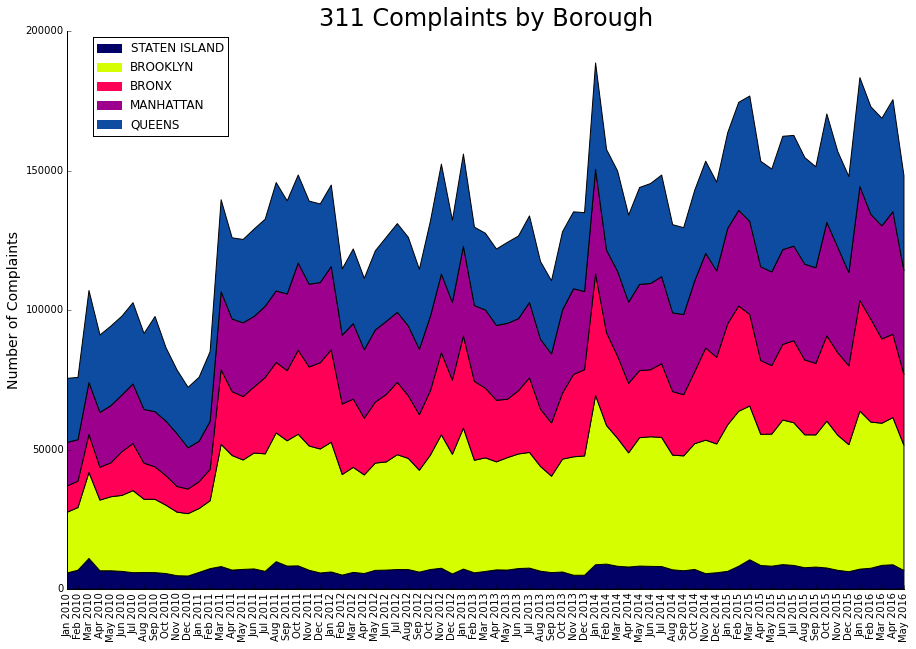

In [20]:
from matplotlib import patches as mpatches

x = np.arange(len(plotdata[0]))

#crude xlabels
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016']
xlabels = []
for year in years:
    for month in months:
        xlabels.append("{0} {1}".format(month,year))

plotcolors = [(1,0,103),(213,255,0),(255,0,86),(158,0,142),(14,76,161),(255,229,2),(0,95,57),\
            (0,255,0),(149,0,58),(255,147,126),(164,36,0),(0,21,68),(145,208,203),(98,14,0)]

#rescaling rgb from 0-255 to 0 to 1
plotcolors = [(color[0]/float(255),color[1]/float(255),color[2]/float(255)) for color in plotcolors]
legendcolors = [mpatches.Patch(color = color) for color in plotcolors]

plt.figure(figsize = (15,10));
plt.stackplot(x,plotdata, colors = plotcolors);
plt.xticks(x,xlabels,rotation=90);
plt.xlim(0,76)
plt.legend(legendcolors,borodict.keys(), bbox_to_anchor=(0.2, 1));
plt.title('311 Complaints by Borough', size = 24)
plt.ylabel('Number of Complaints',size = 14)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

# Sanity checks

So, some parts of this graph bear checking. First, did Staten Island really not increase in complaints over the years? The data below (complaints by by borough by year) suggest that that was the case:

In [21]:
borodata.groupby(by = ['Boro', 'Year']).count()

Date   Month
Boro          Year                
BRONX         2010  142137  142137
              2011  283941  283941
              2012  296502  296502
              2013  302328  302328
              2014  340297  340297
              2015  355017  355017
              2016  161993  161993
BROOKLYN      2010  305827  305827
              2011  482252  482252
              2012  482088  482088
              2013  490979  490979
              2014  557290  557290
              2015  602142  602142
              2016  257628  257628
MANHATTAN     2010  223127  223127
              2011  305727  305727
              2012  314437  314437
              2013  332487  332487
              2014  373895  373895
              2015  417223  417223
              2016  200087  200087
QUEENS        2010  324114  324114
              2011  364158  364158
              2012  358990  358990
              2013  343772  343772
              2014  408389  408389
              2015  455108  455108
              2016  190343  190343
STATEN ISLAND 2010   76069   76069
              2011   88100   88100
              2012   76580   76580
              2013   76622   76622
              2014   90486   90486
              2015   95418   95418
              2016   38660   38660

The other thing that would be worth investigating is what happened between Februrary and March 2011 - complaints doubled during this time. Perhaps some aspect of the pipeline changed during this time, but that's a future story.